Script for generating Fig 5:
- (a) Net offshore transport across the 1000 m isobath, cumulatively summed in s1 space from high to
low density. Transports are averaged over the 5th (dashed) and final (solid) years of the control (black), MW45
(blue), and MW85 (orange) simulations. Offshore transports do not drift over the control simulation, so only
values for the 10th year are shown. (b, c) Age anomalies for the bottom ocean cell, averaged over the final year
of the MW45 (b) and MW85 (c) experiments and normalized by the simulation length. Black lines denote the
1000 m isobath. Open ocean normalized bottom age anomalies for the control simulation are provided in Fig. 2

In [1]:
import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as col
import matplotlib.ticker as mticker
import cmocean.cm as cmo
import matplotlib.path as mpath
### establish link to python functions
import sys
sys.path.append('/home/156/rm2389/Honours_Thesis/python_functions/')
### import required python functions
from masking import shelf_mask_isobath, fill_land
from spatial_averaging import month_weights
import cosima_cookbook as cc
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar
from dask.distributed import Client
client = Client('tcp://localhost:8786')
client

Client Scheduler: tcp://localhost:8786 Dashboard: http://localhost:8787/status,Cluster Workers: 6 Cores: 6 Memory: 18.00 GB


In [2]:
db = '/g/data/v45/rm2389/databases/freshwater_experiments.db' # database path
session = cc.database.create_session(db)
control='01deg_jra55v13_ryf8485_spinup6'
rcp45='01deg_jra55v13_ryf8485_freshRCP45'
rcp85='01deg_jra55v13_ryf8485_freshRCP85'

In [3]:
from matplotlib import rc, rcParams
rc('text', usetex=True)
rc('xtick', labelsize=25) 
rc('ytick', labelsize=25) 
rc('axes', labelsize=25) 
rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

In [4]:
###### loading and computations for isobath transport ##########
## load control + take mean in time (control year 5 and 10 tested and pretty much identical)
vol_trans_across_isobath_binned_control = xr.open_dataset('/g/data/v45/rm2389/Isobath_Transport/control/spinup6_year5/spinup6_vol_trans_across_isobath_binned_1941-06-1942-05.nc', chunks = {'isopycnal_bins':1})
vol_trans_across_isobath_binned_control = vol_trans_across_isobath_binned_control.vol_trans_across_isobath_binned #extract dataarray from dataset
vol_trans_isobath_mean_control = vol_trans_across_isobath_binned_control.mean(dim = 'time')
## load experiment + take mean in time
vol_trans_across_isobath_binned_rcp45_5 = xr.open_dataset('/g/data/v45/rm2389/Isobath_Transport/rcp45/rcp45_year5/rcp45_vol_trans_across_isobath_binned_1941-06-1942-05.nc', chunks = {'isopycnal_bins':1})
vol_trans_across_isobath_binned_rcp45_5 = vol_trans_across_isobath_binned_rcp45_5.vol_trans_across_isobath_binned #extract dataarray from dataset
vol_trans_isobath_mean_rcp45_5 = vol_trans_across_isobath_binned_rcp45_5.mean(dim = 'time')
## load experiment + take mean in time
vol_trans_across_isobath_binned_rcp45_10 = xr.open_dataset('/g/data/v45/rm2389/Isobath_Transport/rcp45/rcp45_year10/rcp45_vol_trans_across_isobath_binned_1946-06-1947-05.nc', chunks = {'isopycnal_bins':1})
vol_trans_across_isobath_binned_rcp45_10 = vol_trans_across_isobath_binned_rcp45_10.vol_trans_across_isobath_binned #extract dataarray from dataset
vol_trans_isobath_mean_rcp45_10 = vol_trans_across_isobath_binned_rcp45_10.mean(dim = 'time')
## load experiment + take mean in time
vol_trans_across_isobath_binned_rcp85_5 = xr.open_dataset('/g/data/v45/rm2389/Isobath_Transport/rcp85/rcp85_year5/rcp85_vol_trans_across_isobath_binned_1941-06-1942-05.nc', chunks = {'isopycnal_bins':1})
vol_trans_across_isobath_binned_rcp85_5 = vol_trans_across_isobath_binned_rcp85_5.vol_trans_across_isobath_binned #extract dataarray from dataset
vol_trans_isobath_mean_rcp85_5 = vol_trans_across_isobath_binned_rcp85_5.mean(dim = 'time')
## load experiment + take mean in time
vol_trans_across_isobath_binned_rcp85_10 = xr.open_dataset('/g/data/v45/rm2389/Isobath_Transport/rcp85/rcp85_year10/rcp85_vol_trans_across_isobath_binned_1946-06-1947-05.nc', chunks = {'isopycnal_bins':1})
vol_trans_across_isobath_binned_rcp85_10 = vol_trans_across_isobath_binned_rcp85_10.vol_trans_across_isobath_binned #extract dataarray from dataset
vol_trans_isobath_mean_rcp85_10 = vol_trans_across_isobath_binned_rcp85_10.mean(dim = 'time')
## extract dimensions
isopycnal_bins = vol_trans_across_isobath_binned_control.isopycnal_bins.values
isobath_index = vol_trans_across_isobath_binned_control.isobath_index.values
## sum along the isobath
net_offshore_trans_control = vol_trans_isobath_mean_control.sum('isobath_index')
net_offshore_trans_rcp45_5 = vol_trans_isobath_mean_rcp45_5.sum('isobath_index')
net_offshore_trans_rcp45_10 = vol_trans_isobath_mean_rcp45_10.sum('isobath_index')
net_offshore_trans_rcp85_5 = vol_trans_isobath_mean_rcp85_5.sum('isobath_index')
net_offshore_trans_rcp85_10 = vol_trans_isobath_mean_rcp85_10.sum('isobath_index')
# ## cumsum from the bottom
net_offshore_trans_control = net_offshore_trans_control.values
net_offshore_trans_control = np.cumsum(net_offshore_trans_control[::-1])[::-1]* 1e-6
net_offshore_trans_rcp45_5 = net_offshore_trans_rcp45_5.values
net_offshore_trans_rcp45_5 = np.cumsum(net_offshore_trans_rcp45_5[::-1])[::-1]* 1e-6
net_offshore_trans_rcp45_10 = net_offshore_trans_rcp45_10.values
net_offshore_trans_rcp45_10 = np.cumsum(net_offshore_trans_rcp45_10[::-1])[::-1]* 1e-6
net_offshore_trans_rcp85_5 = net_offshore_trans_rcp85_5.values
net_offshore_trans_rcp85_5 = np.cumsum(net_offshore_trans_rcp85_5[::-1])[::-1]* 1e-6
net_offshore_trans_rcp85_10 = net_offshore_trans_rcp85_10.values
net_offshore_trans_rcp85_10 = np.cumsum(net_offshore_trans_rcp85_10[::-1])[::-1]* 1e-6

In [5]:
import matplotlib.cm as cm
cmap = cm.get_cmap('Oranges')
orange_color = cmap(0.75)

In [6]:
def DSW_transport_full(ax, control = net_offshore_trans_control, rcp45_5 = net_offshore_trans_rcp45_5, rcp45_10 = net_offshore_trans_rcp45_10, rcp85_5 = net_offshore_trans_rcp85_5, rcp85_10 = net_offshore_trans_rcp85_10, isopycnal_bins = isopycnal_bins):
    ax.plot(net_offshore_trans_control,isopycnal_bins,color = 'k', linewidth = 2, label = 'Control')
    ax.plot(rcp45_5,isopycnal_bins,color = 'mediumblue', linestyle = ':', linewidth = 2, label = 'MW45 (Year 5)')
    ax.plot(rcp45_10,isopycnal_bins,color = 'mediumblue', linewidth = 2, label = 'MW45 (Year 10)')
    ax.plot(net_offshore_trans_rcp85_5,isopycnal_bins,color = orange_color, linestyle = '--', linewidth = 2, label = 'M (Year 5)')
    ax.plot(net_offshore_trans_rcp85_10,isopycnal_bins,color =orange_color,linewidth = 2, label = 'M (Year 10)')
    ax.set_ylabel(r'$\sigma_{1}$ (kg m$^{-3}$)', fontsize = 35)
    ax.set_xlabel('Offshore transport across 1000m isobath (Sv)', fontsize = 35)
    ax.plot([0,0],[30,32.8],'k',linewidth=0.5)
    ax.set_ylim((32.8,31.6))
    ax.set_xlim((-1,11))
    ax.legend(loc = 'top right', fontsize = 30) 

In [9]:
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [7]:
def antarctic_map(ax, isobath_linewidth, grid, north, isobath_colour = 'k'):
    ax.contour(xt_ocean, yt_ocean,land_mask,[0,1], colors = 'k', linewidth = 1, alpha = 0.3, transform=ccrs.PlateCarree())
    ax.contour(shelf_mask.xt_ocean, shelf_mask.yt_ocean,shelf_mask,[0,1], colors = isobath_colour, linewidth = isobath_linewidth, transform=ccrs.PlateCarree())
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([-180, 180, -90, north], ccrs.PlateCarree())
    if grid == True:
        gl = ax.gridlines(linewidth = 1, color = 'grey', linestyle = '--')
        gl.ylocator = mticker.FixedLocator([-90,-80,-70, -60, -50])

In [8]:
ht = cc.querying.getvar(control,'ht',session, n=1) 
ht = ht.sel(yt_ocean = slice(-90,-55))
land_mask = np.squeeze(ht.values)
land_mask = land_mask * 0
land_mask[np.isnan(land_mask)] = 1
yt_ocean =ht.yt_ocean.values
xt_ocean =ht.xt_ocean.values
ht_shelf , shelf_mask = shelf_mask_isobath(ht)

In [10]:
## bottom age
bottom_age_control = xr.open_dataset('/g/data/v45/rm2389/Water_Mass_Tracers/control_bottom_age_year_10.nc', chunks = {'xt_ocean':300, 'yt_ocean':300})
bottom_age_control = bottom_age_control.bottom_age_control
bottom_age_rcp45 = xr.open_dataset('/g/data/v45/rm2389/Water_Mass_Tracers/rcp45_bottom_age_year_10.nc', chunks = {'xt_ocean':300, 'yt_ocean':300})
bottom_age_rcp45 = bottom_age_rcp45.bottom_age_rcp45
bottom_age_rcp85 = xr.open_dataset('/g/data/v45/rm2389/Water_Mass_Tracers/rcp85_bottom_age_year_10.nc', chunks = {'xt_ocean':300, 'yt_ocean':300})
bottom_age_rcp85 = bottom_age_rcp85.bottom_age_rcp85
bottom_age_control_norm = bottom_age_control/47
bottom_age_rcp45_norm = bottom_age_rcp45/47
bottom_age_rcp85_norm = bottom_age_rcp85/47
bottom_age_rcp45_anom = bottom_age_rcp45_norm - bottom_age_control_norm
bottom_age_rcp85_anom = bottom_age_rcp85_norm - bottom_age_control_norm
bottom_age_rcp45_anom = bottom_age_rcp45_anom.where(bottom_age_rcp45_anom != 0)
bottom_age_rcp85_anom = bottom_age_rcp85_anom.where(bottom_age_rcp85_anom != 0) 

In [11]:
def age_plot_bottom(ax0,ax1,colors):
    fill_land(land_mask, ax0, yt_ocean, xt_ocean, fill_colour = 'silver', a = 0.2)
    fill_land(land_mask, ax1, yt_ocean, xt_ocean, fill_colour = 'silver', a = 0.2)
    norm = col.Normalize(vmin=-0.5,vmax=0.5)
    ax0.contour(xt_ocean, yt_ocean,land_mask,[0,1], colors = 'k', linewidth = 1, alpha = 0.3, transform = ccrs.PlateCarree() )
    ax0.contour(shelf_mask.xt_ocean, shelf_mask.yt_ocean,shelf_mask,[0,1], colors = 'k', alpha =0.8, linewidth = 1, transform = ccrs.PlateCarree())
    ax1.contour(xt_ocean, yt_ocean,land_mask,[0,1], colors = 'k', linewidth = 1, alpha = 0.3, transform = ccrs.PlateCarree() )
    ax1.contour(shelf_mask.xt_ocean, shelf_mask.yt_ocean,shelf_mask,[0,1], colors = 'k', alpha =0.8, linewidth = 1, transform = ccrs.PlateCarree())

    ## age difference
    cbar= ax0.pcolormesh(bottom_age_rcp45_anom.xt_ocean,bottom_age_rcp45_anom.yt_ocean,-bottom_age_rcp45_anom,cmap = colors, norm = norm,transform = ccrs.PlateCarree())
    ax1.pcolormesh(bottom_age_rcp85_anom.xt_ocean,bottom_age_rcp85_anom.yt_ocean,-bottom_age_rcp85_anom,cmap = colors, norm = norm,transform = ccrs.PlateCarree())

    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax0.set_boundary(circle, transform=ax0.transAxes)
    ax0.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())
    ax1.set_boundary(circle, transform=ax1.transAxes)
    ax1.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())

    return cbar

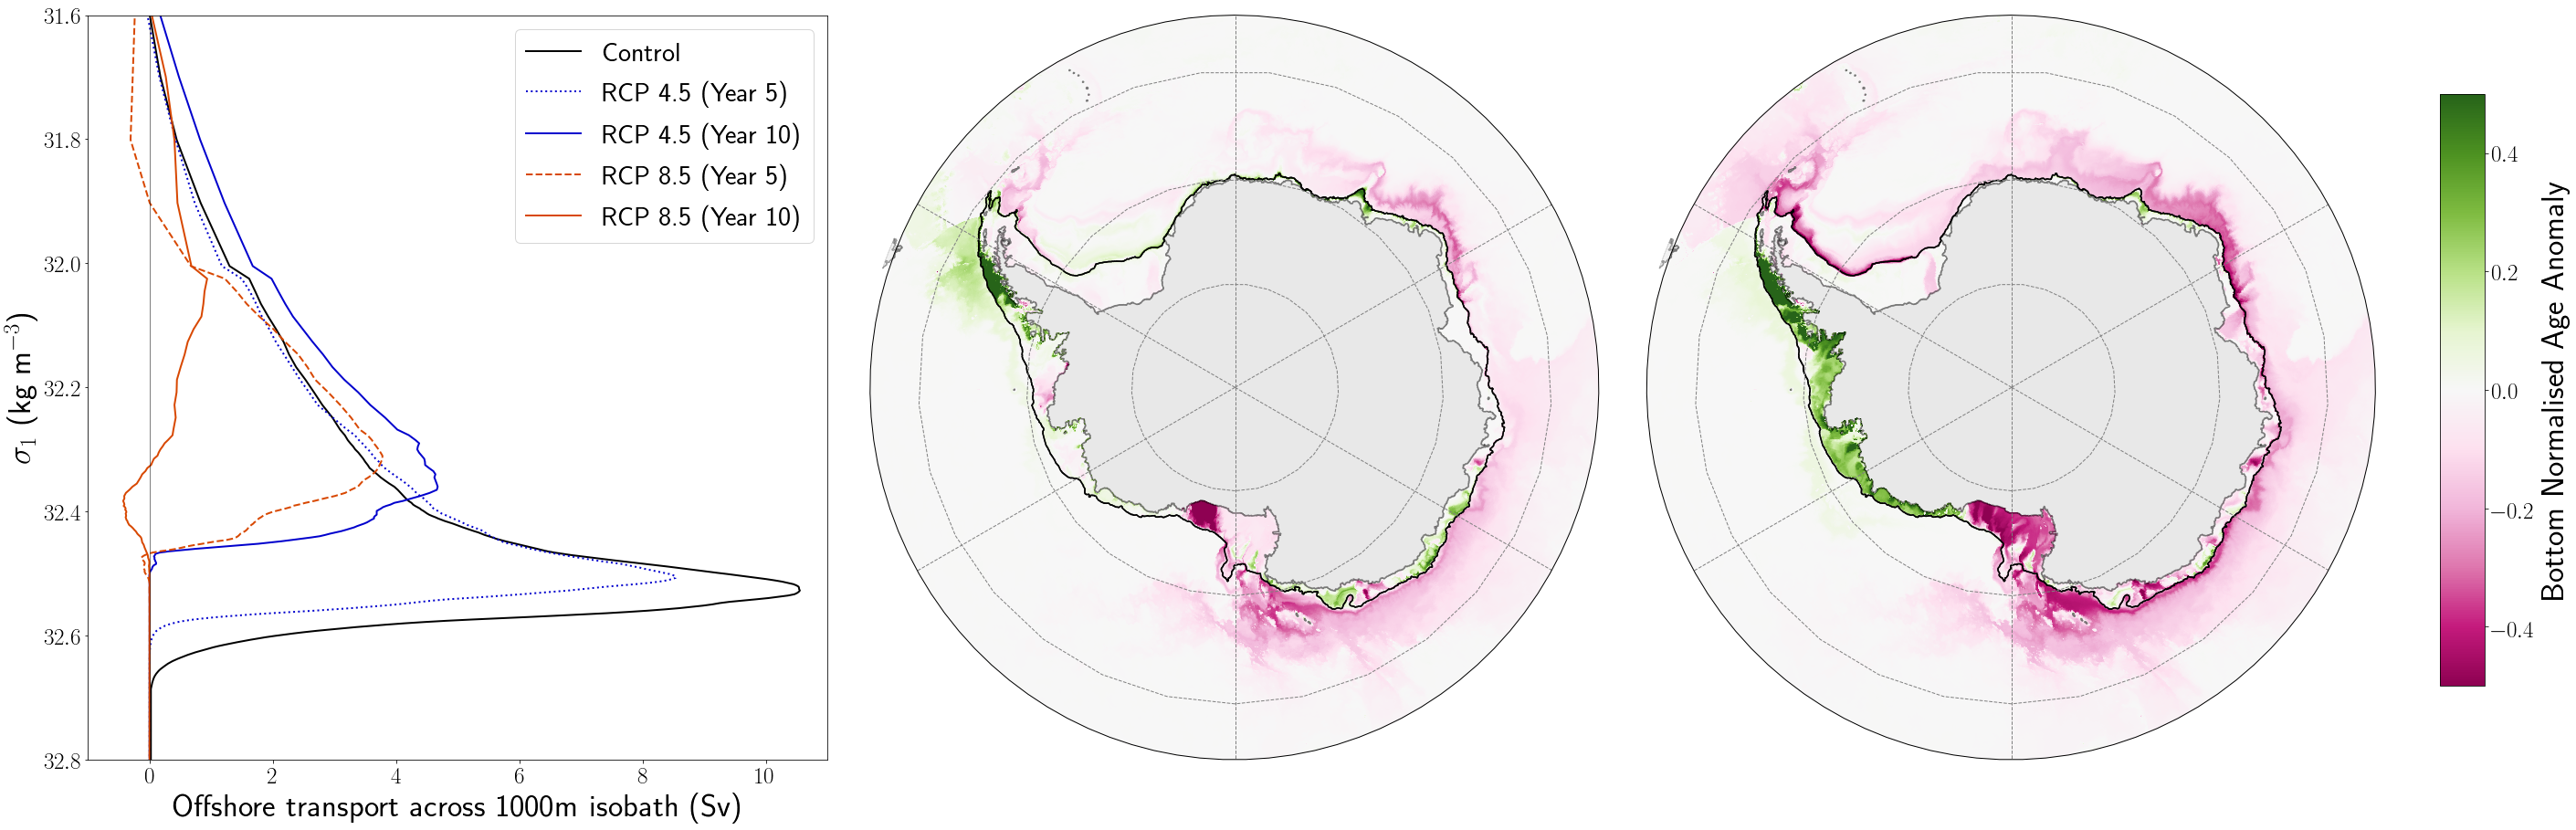

In [18]:
fig = plt.figure(1, figsize = (45,15))
gs = gridspec.GridSpec(1,3)
ax0, ax1, ax2= plt.subplot(gs[0]),plt.subplot(gs[1], projection=ccrs.SouthPolarStereo()), plt.subplot(gs[2], projection=ccrs.SouthPolarStereo())
gs.update(wspace = 0.05)
DSW_transport_full(ax0)

fill_land(land_mask, ax1, yt_ocean, xt_ocean, fill_colour = 'silver', a = 0.2)
fill_land(land_mask, ax2, yt_ocean, xt_ocean, fill_colour = 'silver', a = 0.2)

norm = col.Normalize(vmin=0,vmax=0.75)  
antarctic_map(ax1, 6, True, -55, isobath_colour = 'k')
antarctic_map(ax2, 6, True, -55, isobath_colour = 'k')
colors = age_plot_bottom(ax1,ax2,'PiYG')
cax = plt.axes([0.92, 0.2, 0.015, 0.6])
cbar=plt.colorbar(colors, cax = cax,orientation='vertical', shrink = 0.5)
cbar.set_label(r'Bottom Normalised Age Anomaly', fontsize = 35)

figurepath = 'Fig5.png'
fig.savefig(figurepath, dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format='png',
            transparent=False, bbox_inches='tight', pad_inches=0.1,
            frameon=None)

plt.show()   